# Cybernetic Multiarmed Bandits

## Comparing Multiple Algorithms using Repetitions

In [1]:
#Dependencies
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
%matplotlib inline
import pickle

#Arms
from SMPyBandits.Arms import Bernoulli, Gaussian, Constant
from mabarms import ExtendedBernoulli

#Policies
from SMPyBandits.Policies import Uniform, EmpiricalMeans, UCBalpha, UCBV, klUCB, Thompson, SoftMix
from mabalgs import SafeEpsilonGreedy, SafeUCB, SafeUCBalpha, ClassicEpsilonGreedy, ClassicEpsilonDecreasing, ClassicOptimisticGreedy, SafeKLUCB, GamblerBernoulliUCB

#Sim
from mabsim import mabs
from mabplot import mabplt

Info: Using the Jupyter notebook version of the tqdm() decorator, tqdm_notebook() ...


## Setting (10-Gaussian-Arms)

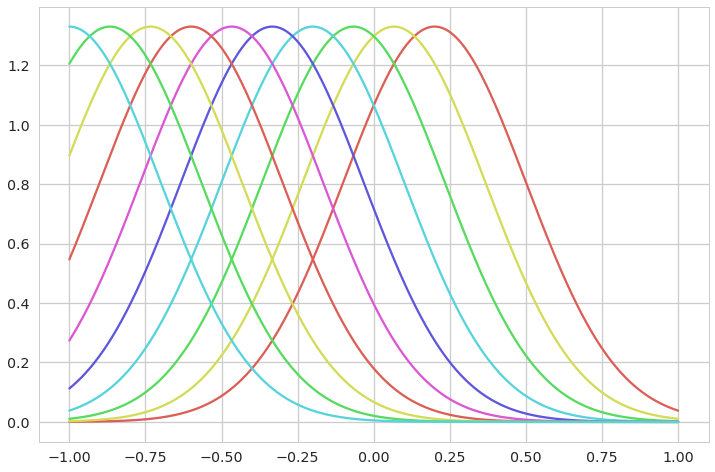

In [2]:
plt.rcParams['figure.figsize'] = (12, 8)


# BERNOULLI ARMS :

#means = np.array([0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5, 0.55])
#means = np.array([0.3, 0.4, 0.4, 0.4, 0.4, 0.4, 0.45, 0.55, 0.6])
#means = np.concatenate((np.repeat(0.1, 15), np.repeat(0.7, 5), [0.9]))
#means = np.concatenate((np.repeat(0.1, 30), np.repeat(0.6, 5), [0.8]))

maxr = +1.0
minr = -1.0
ampl = maxr - minr

#A = [ExtendedBernoulli(m, maxr=maxr, minr=minr) for m in means]


# NORMALLY RANDOM GAUSSIAN ARMS :

# draw random means for gaussian arms based on a given generative distribution
#generative_mean = 0.0
#generative_variance = 2.0
#means = np.random.normal(generative_mean, generative_variance, k)

#number of arms
#k = len(means)

# ONE POSITIVE ALL NEGATIVE GAUSSIAN ARMS :

#k = 30
#means = np.repeat(-0.1, k)
#means[k-1] = 0.1
#sigma = 0.5


# LINEARLY INCREASING GAUSSIAN ARMS :

# linear means for each arm
k = 10
means = np.linspace(-1.0, 0.2, k)
#means = np.linspace(-0.5, 0.5, k)

#variance for each arm
#sigma = 1.0
sigma = 0.3

#arms objects (normal distribution, non-truncated)
#A = [Gaussian(mu, sigma=sigma, mini=float('-inf'), maxi=float('inf')) for mu in means]

#arms objects (normal distribution, truncated)
A = [Gaussian(mu, sigma=sigma, mini=minr, maxi=maxr) for mu in means]

#show distributions
x = np.linspace(minr, maxr, 1000)
idx = np.argsort(means)[::-1] #order
#for i, mu in enumerate(means):
for i in idx:
    mu = means[i]
    plt.plot(x, mlab.normpdf(x, mu, sigma), label="$\mu_{" + str(i+1) + "}=" + str(mu) + "$")
#plt.legend()
plt.show()

In [3]:
#initial budget
b_0 = 10.0
b_s = 5.0

#algorithms
G = [
     SafeEpsilonGreedy(k, epsilon=0.1, inibudget=b_0, safebudget=b_s, lower=minr, amplitude=ampl),
     ClassicEpsilonGreedy(k, epsilon=0.1, lower=minr, amplitude=ampl), 
     SafeKLUCB(k, inibudget=b_0, safebudget=b_s, lower=minr, amplitude=ampl),
     klUCB(k, lower=minr, amplitude=ampl),
     SafeUCBalpha(k, alpha=1.0*ampl, inibudget=b_0, safebudget=b_s, lower=minr, amplitude=ampl),
     UCBalpha(k, alpha=1.0*ampl, lower=minr, amplitude=ampl)
     #SoftMix(k, lower=minr, amplitude=ampl), 
     #EmpiricalMeans(k, lower=minr, amplitude=ampl),
     ###UCBalpha(k, alpha=4.0*ampl, lower=minr, amplitude=ampl), 
     ###UCBalpha(k, alpha=0.5*ampl),
     #UCBV(k, lower=minr, amplitude=ampl),
     ##Thompson(k), 
    ]

#window average parameter (for graphics)
win = None #tau//10

## First Simulation

 - Several Repetitions 
 - Short Horizon

In [4]:
#time-horizon
tau = 100 

#repetitions
n = 200

M = mabs(A, G, tau, repetitions=n, window=win, inibudget=b_0)
M.run(tqdm_leave=True)

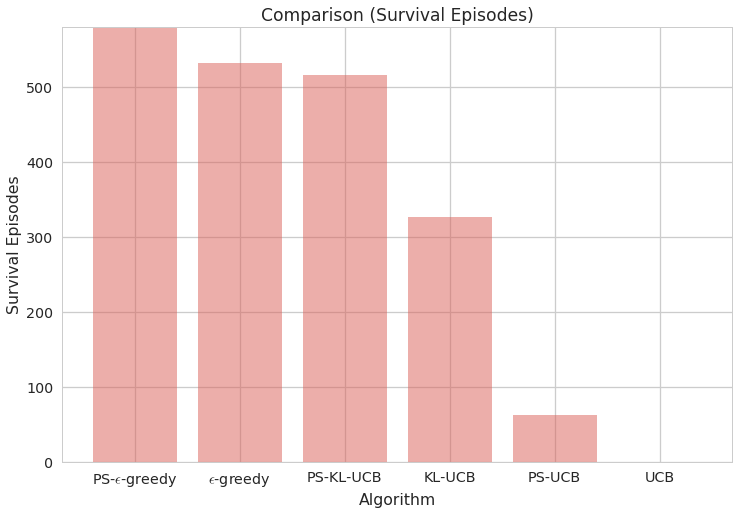

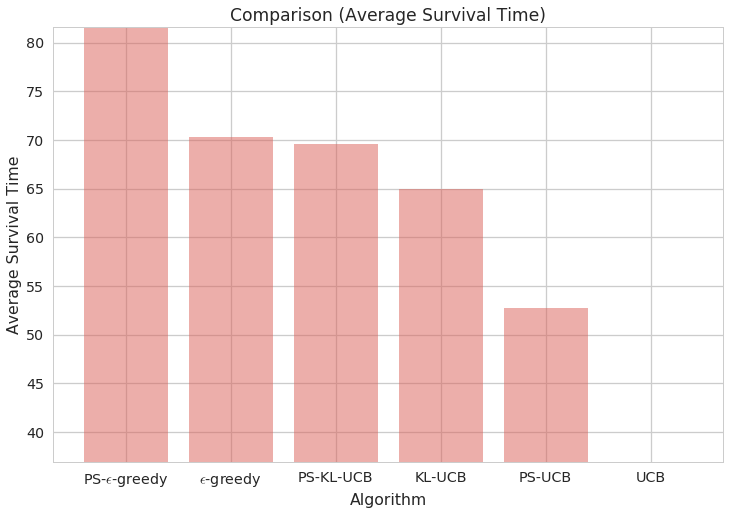

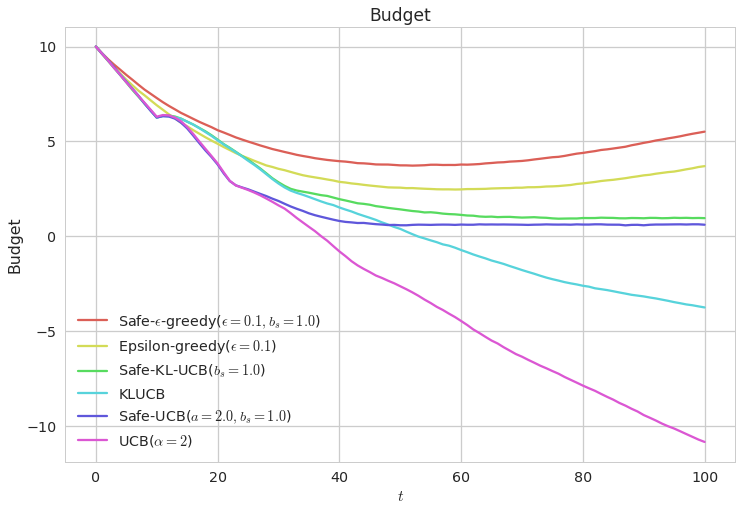

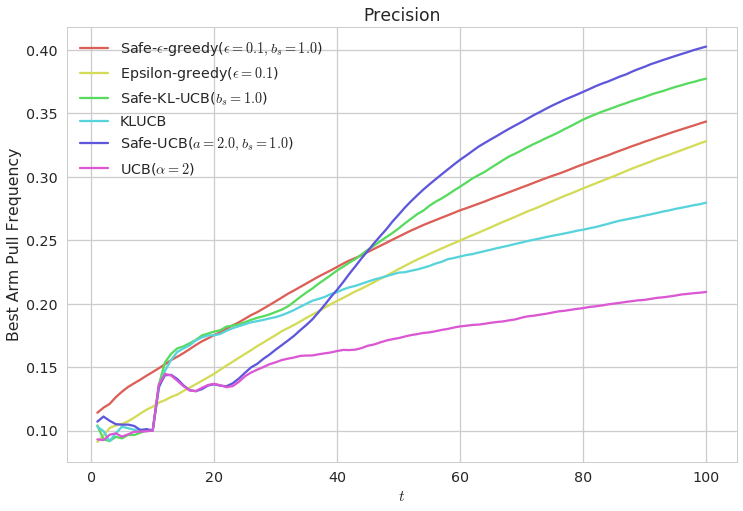

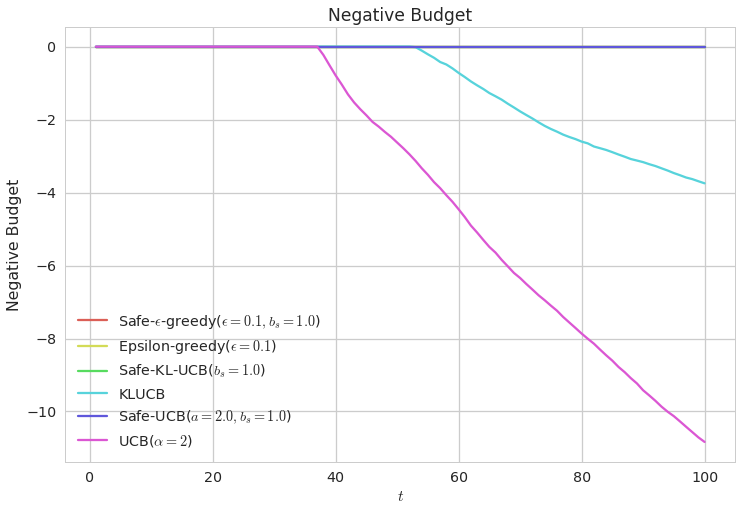

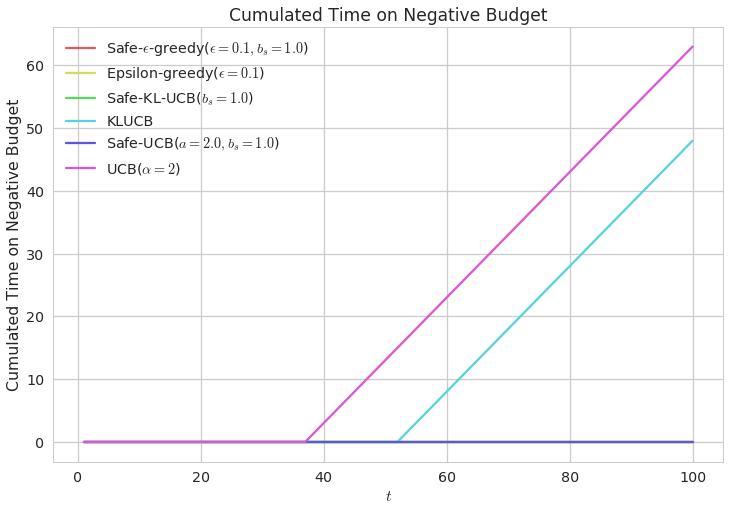

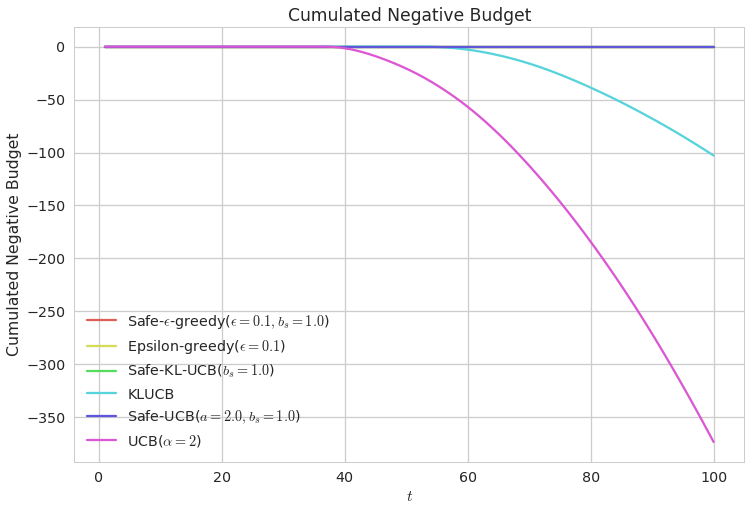

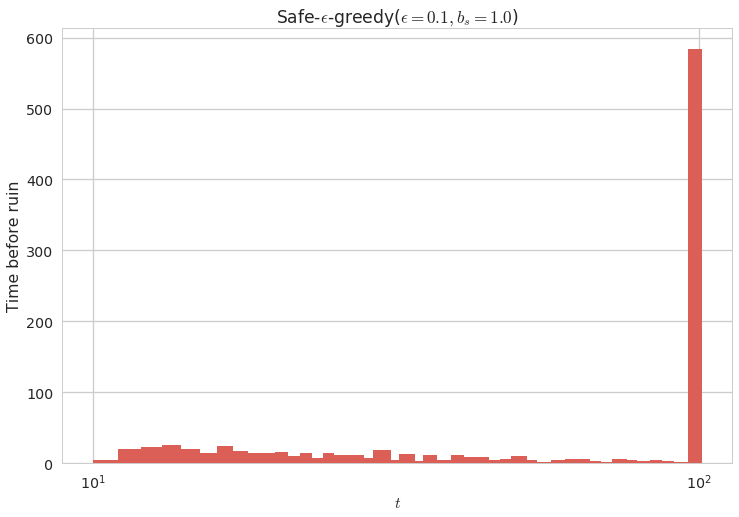

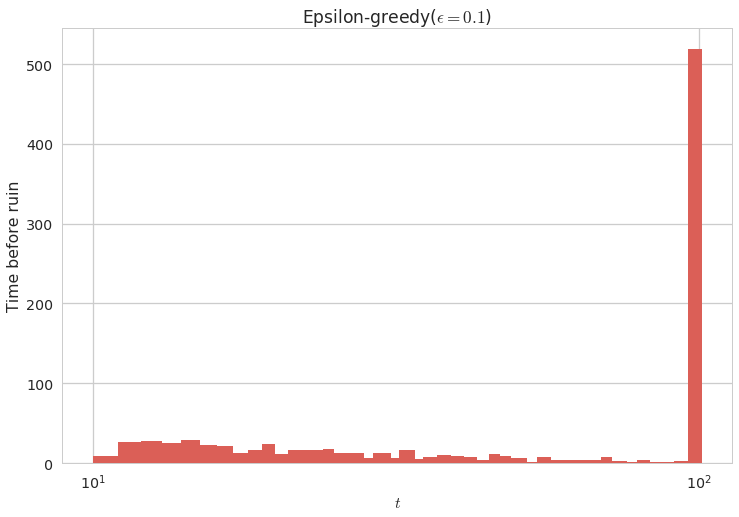

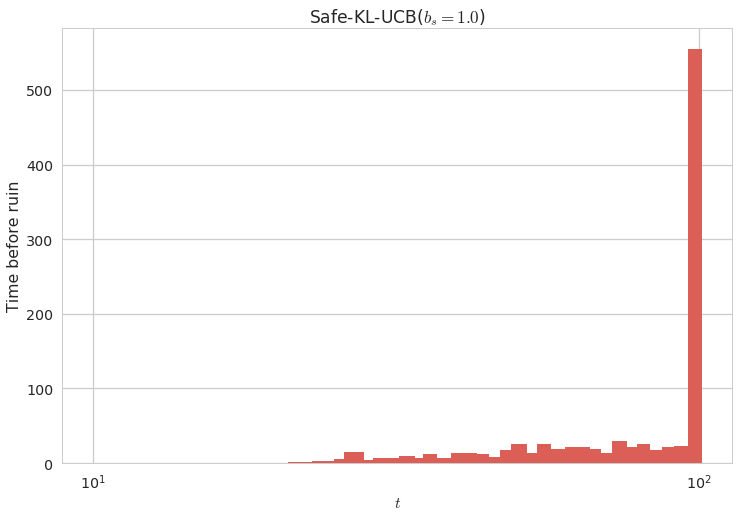

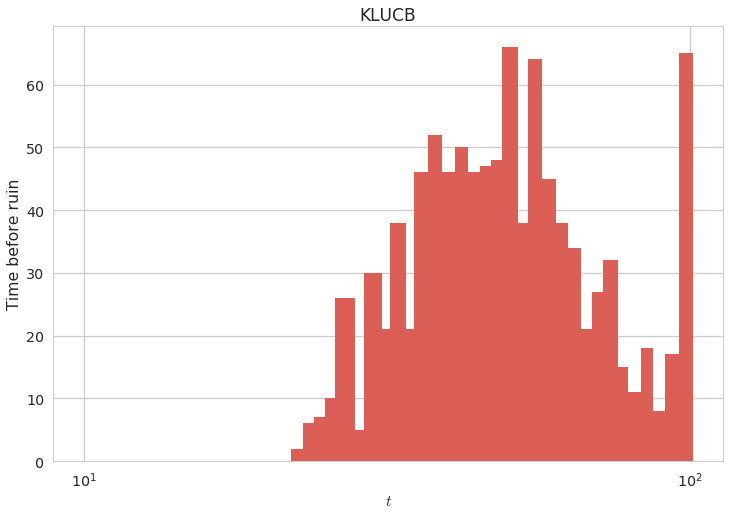

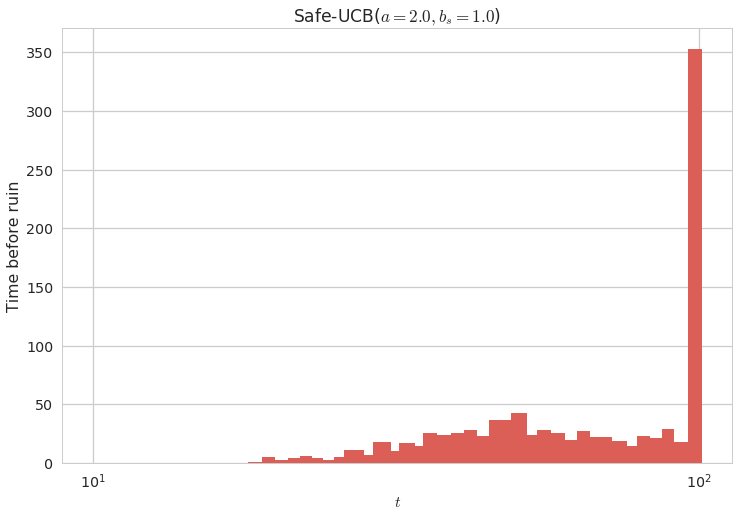

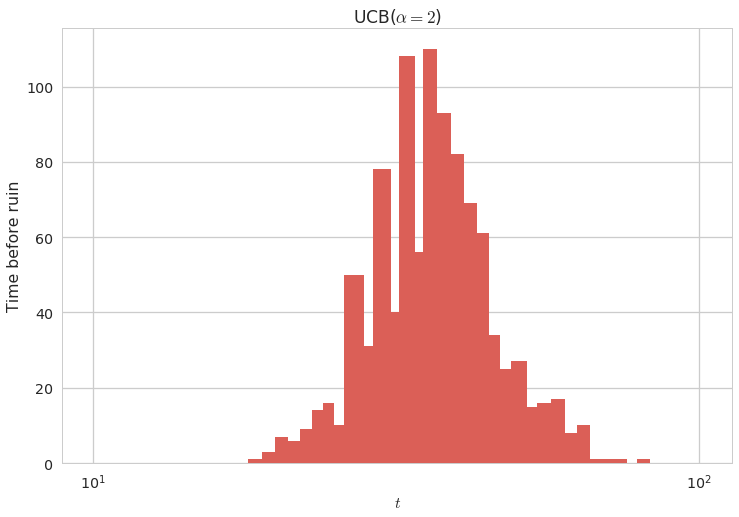

In [18]:
P = mabplt(M)

rate_names = [
    "Survival Episodes Rate", 
    "Survival Time (before ruin or end) (averaged over episodes)", 
    "Cumulative Time on Negative Budget (averaged over episodes)", 
    "Cumulative Negative Budget (averaged over episodes)"
    ]
#rate_algs = [str(g) for g in M.G]
rate_algs = ["PS-$\epsilon$-greedy", "$\epsilon$-greedy", "PS-KL-UCB", "KL-UCB", "PS-UCB", "UCB"]
rate_values = [1.0 - M.senb / M.n, M.MTTNB, M.mstnb, M.msnb]
df = pd.DataFrame(rate_values, rate_names, columns=rate_algs)
display(df)

P.plot_comp_algs_ruined_episodes(show=False)
plt.xticks(np.arange(M.m, dtype='int'), rate_algs, rotation='horizontal')
#plt.savefig('surv_ep_t100.pdf')
plt.show()

P.plot_comp_algs_survival_time()
#P.plot_comp_algs_cumulated_negative_budget()

P.plot_budget_progression()

P.plot_precision_progression()

P.plot_negative_budget_progression()

P.plot_negative_budget_time_progression()

P.plot_cumulated_negative_budget_progression()

for j, g in enumerate(M.G):
    P.plot_survival_histogram(j=j, title=str(g))

## Second Simulation

 - Few Repetitions 
 - Long Horizon

In [21]:
#time-horizon
tau = 15000 

#repetitions
n = 5

M2 = mabs(A, G, tau, repetitions=n, window=win, inibudget=b_0)
M2.run(tqdm_leave=True)

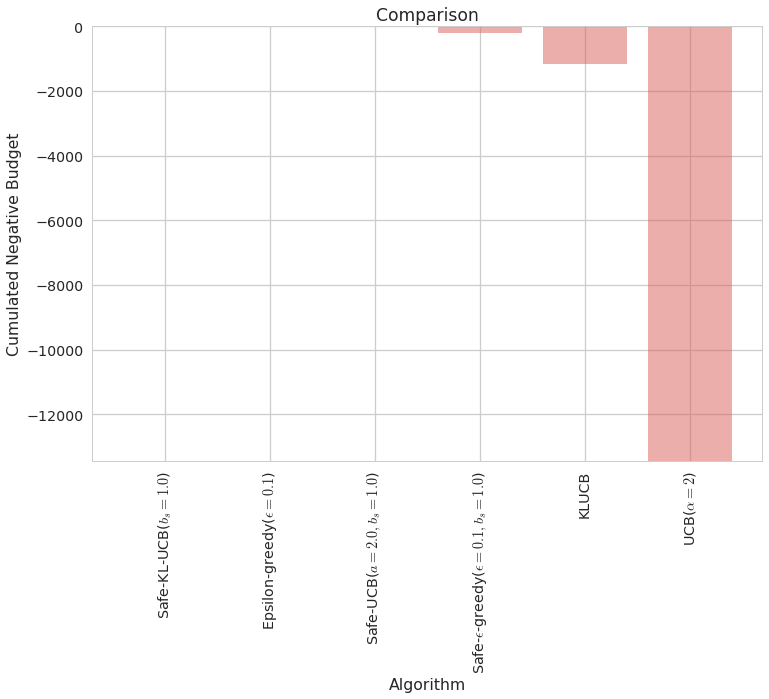

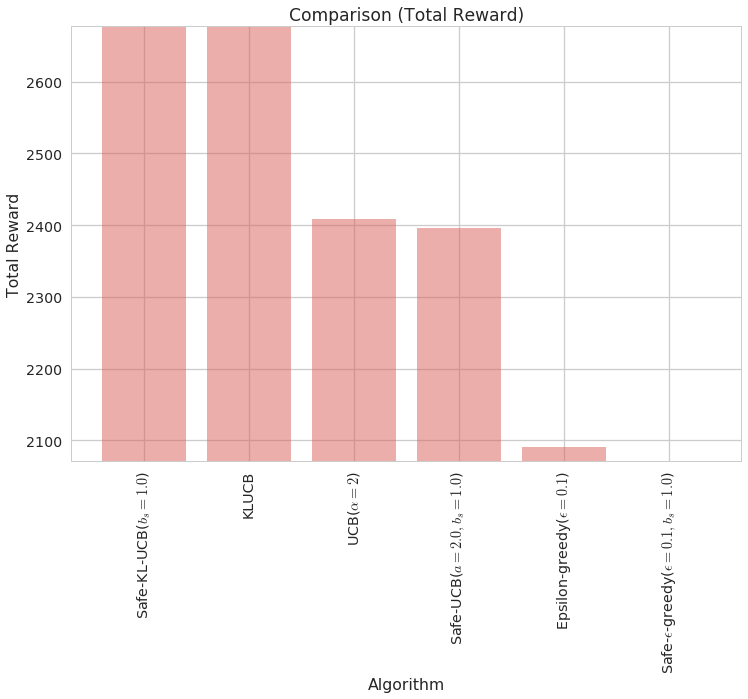

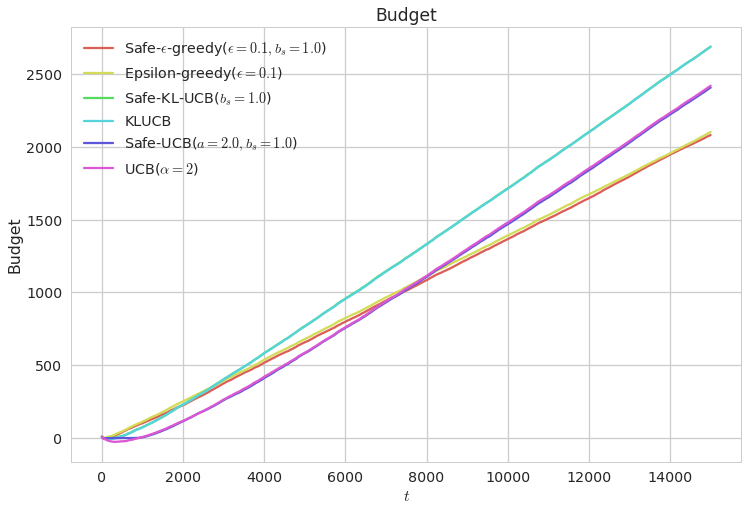

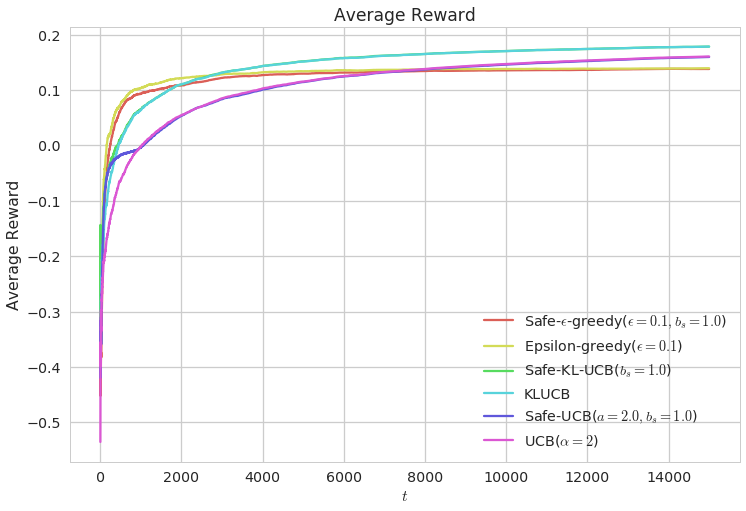

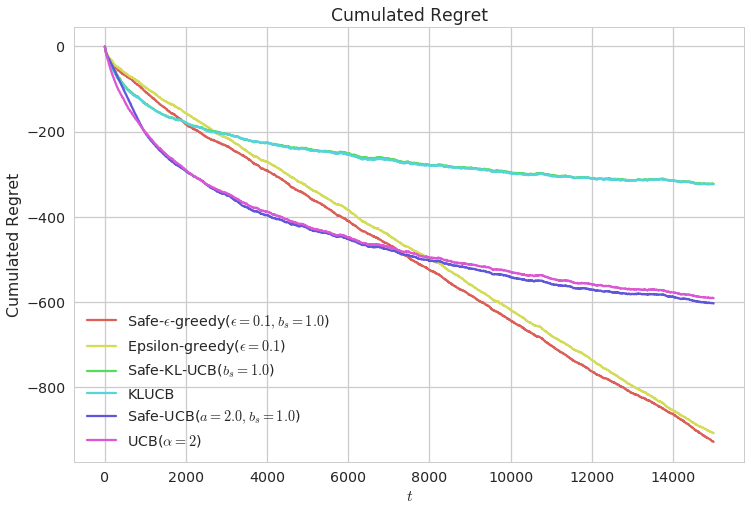

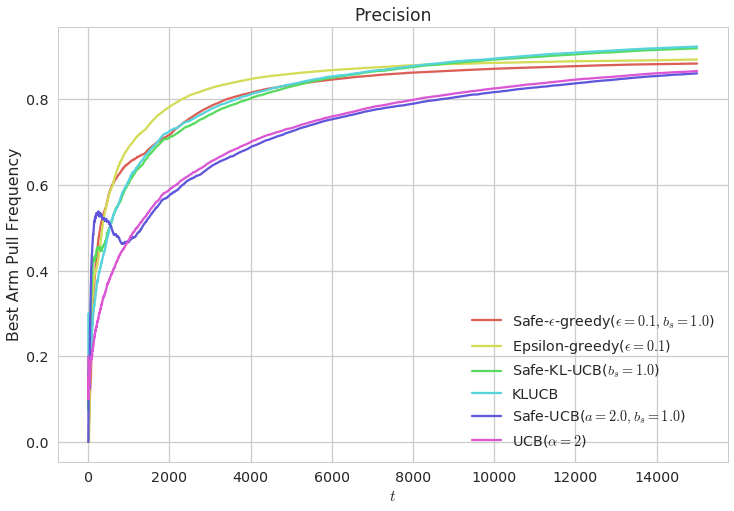

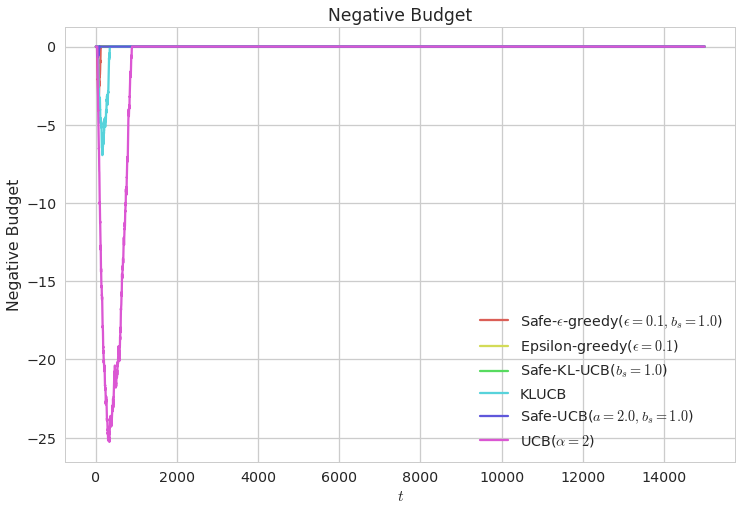

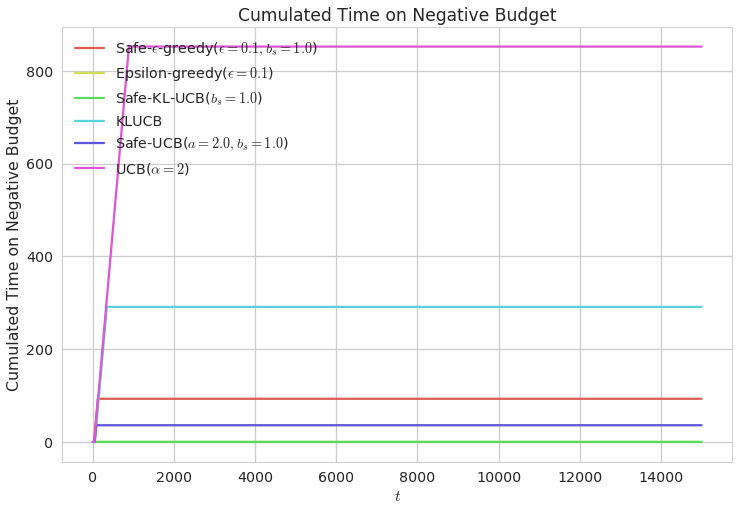

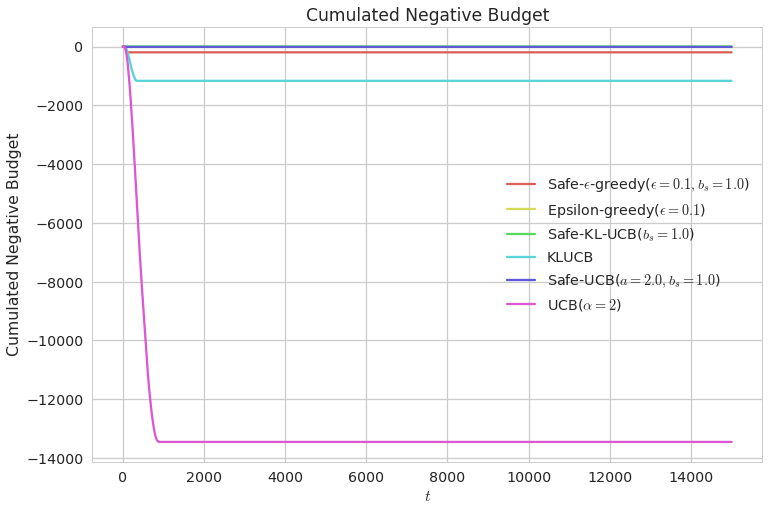

In [22]:
P = mabplt(M2)

P.plot_comp_algs_cumulated_negative_budget()
P.plot_comp_algs_total_rewards()

P.plot_budget_progression()
P.plot_average_reward_progression()

P.plot_cumulated_regret_progression(show=False)
plt.savefig('regret_t15000.pdf')
plt.show()

P.plot_precision_progression()

P.plot_negative_budget_progression()
P.plot_negative_budget_time_progression()
P.plot_cumulated_negative_budget_progression()

## Load and Save

In [16]:
# Load the simulation back from the pickle file.
with open('mab.pickle', 'rb') as f:
M = pickle.load(f)

In [ ]:
# Save the simulation into a pickle file.
with open('mab.pickle', 'wb') as f:
    pickle.dump(M, f, pickle.HIGHEST_PROTOCOL)